In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel, ConditionalVAE, HeteroscedasticModel, IAFConditionalVAE
from inn_utils import (train_online_ml, compute_metrics, train_online_kl, 
                       train_online_heteroscedastic, train_online_iaf)
from process_models import simulate_ricker_params, simulate_ricker, load_test_ricker
from viz import (plot_true_est_scatter, plot_true_est_posterior, 
                 plot_losses, plot_sbc, plot_metrics, plot_variance,
                 plot_true_est_posterior_samples)
import diagnostics as diag

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Conditional Invertible Neural Network (cINN)

## Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [21]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

<p>We will also append a dummy noise parameter to the true parameter vector.</p>

In [22]:
def add_noise_var(X_batch, theta_batch):
    """
    Adds a column of uniform noise to the true parameter values.
    """
    
    noise_col = tf.random_uniform(shape=(theta_batch.shape[0], 1))
    theta_batch = tf.concat((theta_batch, noise_col), axis=-1)
    return X_batch, theta_batch

## Initialization 

In [23]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

### Create test data

In [24]:
# For scatter
X_test, theta_test = load_test_ricker()

### Create networks

In [25]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

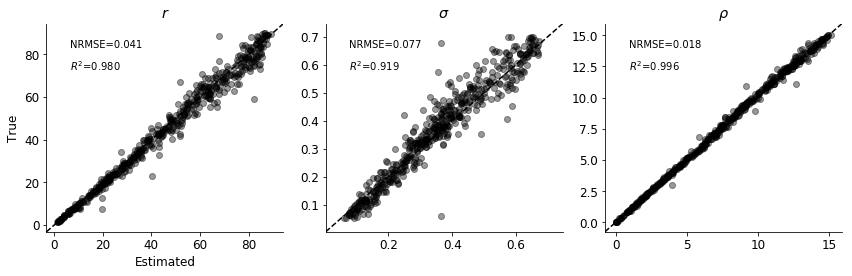

In [31]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:3], figsize=(12, 4))

### Checkpoint manager

In [28]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/ricker\ckpt-final


## Train the model

In [139]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online_ml(model, optimizer, simulate_ricker, iterations_per_epoch, 
#                                  batch_size, p_bar, clip_value=clip_value, 
#                                  global_step=global_step, transform=add_noise_var)

#         # Store checkpoint
#         manager.save()

## Evaluate the trained model

### Posterior means (recovery)

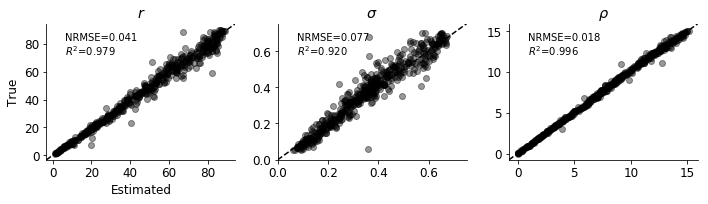

In [33]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:3], 
                      figsize=(10, 3), filename='Ricker')

### Full posterior (visual inspection)

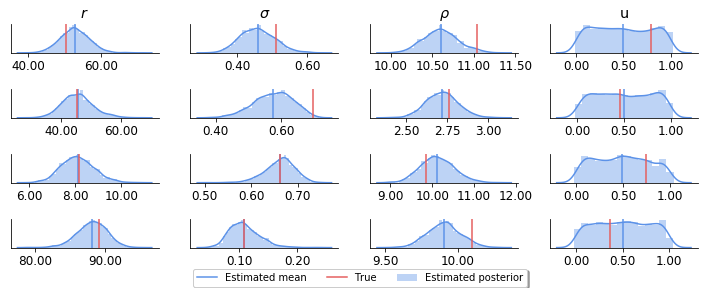

In [42]:
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))

### Simulation-based calibration

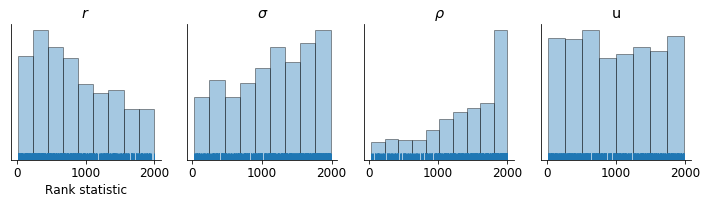

In [43]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 3))

### Errors

In [143]:
n_bootstrap = 100
theta_samples = model.sample(X_test, n_samples_posterior, to_numpy=True)
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_ricker_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_cINN.pkl', 'wb+'))

# Conditional Variational Autoencoder (cVAE)

## Initialization

### Training hyperparameters

In [149]:
# --- Structure of the VAE --- #
vae_meta = {
    'n_units': [128, 128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = len(param_names)
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
z_dim = 4
beta = tfe.Variable(0.0, dtype=tf.float32)
beta_step = 500
beta_increment = 0.01
beta_max = 0.1
epochs = 100
iterations_per_epoch = 1000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

### Create test data

In [9]:
# For scatter
X_test, theta_test = load_test_ricker()

### Create networks

In [150]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
vae = ConditionalVAE(vae_meta, theta_dim, z_dim, summary_net)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

Instructions for updating:
Colocations handled automatically by placer.


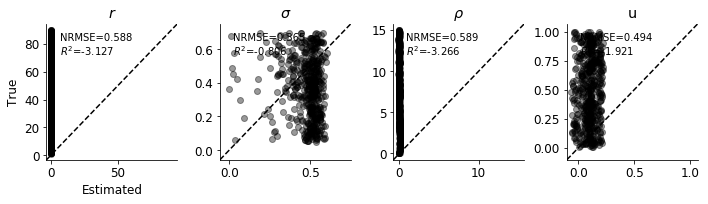

In [11]:
plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Create checkpoints

In [151]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=vae)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker_vae', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/ricker_vae\ckpt-final


## Train the model

In [13]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        losses = train_online_kl(vae, optimizer, simulate_ricker, iterations_per_epoch, 
                            batch_size, beta, p_bar, clip_value=clip_value, 
                            global_step=global_step, beta_step=beta_step, beta_increment=beta_increment)
        
        # Plot stuff
        plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 3))

        # Store checkpoint
        manager.save()

## Evaluate the trained model

### Posterior means (recovery)

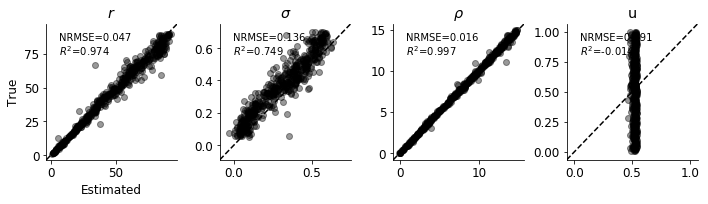

In [152]:
plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Full posterior (visual)

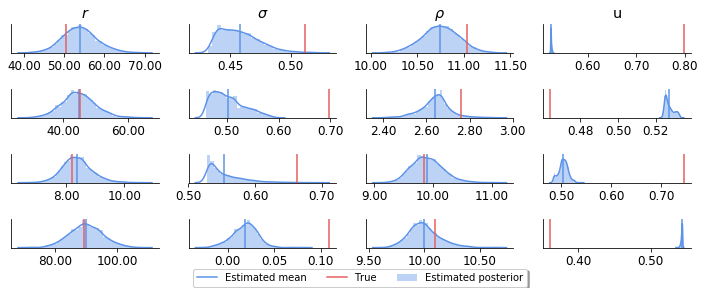

In [15]:
plot_true_est_posterior(vae, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))

### Simulation-based calibration

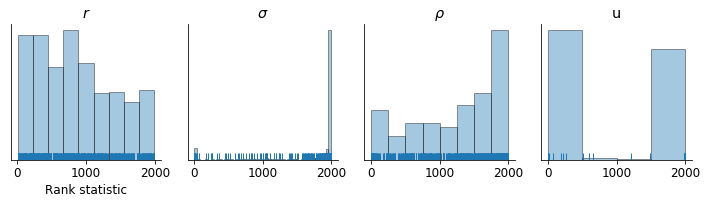

In [16]:
plot_sbc(vae, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 3))

### Errors

In [43]:
n_bootstrap = 100
theta_samples = vae.sample(X_test, n_samples_posterior, to_numpy=True)
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_ricker_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_cVAE.pkl', 'wb+'))

# DeepInference (heteroscedastic loss)

## Initialization

### Training hyperparameters

In [153]:
# --- Structure of the inference network--- #
model_meta = {
    'n_units': [128, 128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = len(param_names)
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

### Create test data

In [46]:
# For scatter
X_test, theta_test = load_test_ricker()

### Create networks

In [154]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model_di = HeteroscedasticModel(model_meta, theta_dim, summary_net)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

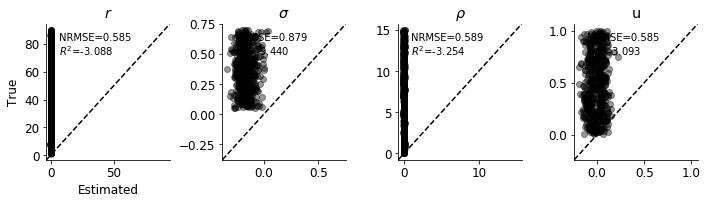

In [155]:
plot_true_est_scatter(model_di, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Create checkpoints

In [156]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model_di)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker_deep_inference', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/ricker_deep_inference\ckpt-final


## Train the model

In [ ]:
# %%time
# for ep in range(1, epochschs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
#         losses = train_online_heteroscedastic(model, optimizer, simulate_ricker, iterations_per_epoch, 
#                             batch_size, p_bar, clip_value=clip_value, global_step=global_step)
        
#         # Plot stuff
#         plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 3))

#         # Store checkpoint
#         manager.save()

## Evaluate the trained model

### Posterior means (recovery)

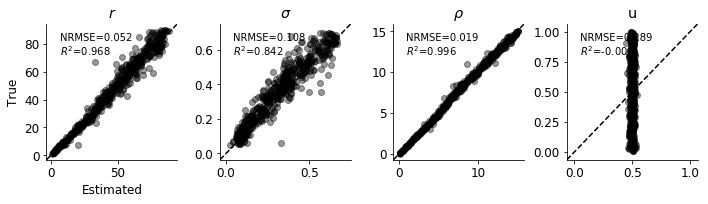

In [157]:
plot_true_est_scatter(model_di, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Full posteriors (visual)

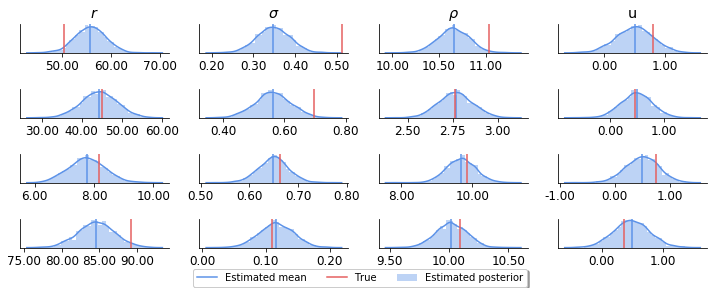

In [51]:
plot_true_est_posterior(model_di, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))

### Simulation-based calibration

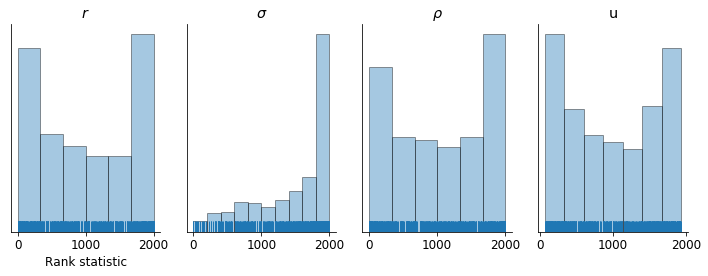

In [52]:
plot_sbc(model_di, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))

### Errors

In [54]:
n_bootstrap = 100
theta_samples = model_di.sample(X_test, n_samples_posterior, to_numpy=True)
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_ricker_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_di.pkl', 'wb+'))

# cVAE with Inverse Autoregressive Flow cVAE-IAF

## Initialization

### Training hyperparameters

In [158]:
# --- Structure of the VAE --- #
vae_iaf_meta = {
    'n_units': [128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = len(param_names)
n_iaf = 2
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
z_dim = 4
beta = tfe.Variable(0.0, dtype=tf.float32)
beta_max = 0.1
beta_step = 500
beta_increment = 0.01
epochs = 100
iterations_per_epoch = 1000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

### Create test data

In [159]:
# For scatter
X_test, theta_test = load_test_ricker()

### Create networks

In [160]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
vae_iaf = IAFConditionalVAE(vae_iaf_meta, theta_dim, z_dim, n_iaf, summary_net)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

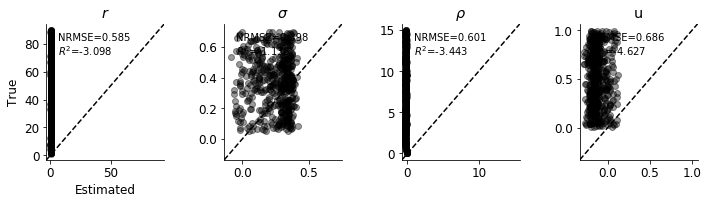

In [161]:
plot_true_est_scatter(vae_iaf, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Create checkpoints

In [163]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=vae_iaf)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker_vae_iaf', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/ricker_vae_iaf\ckpt-final


## Train the model

In [ ]:
# %%time
# for ep in range(1, 30+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
#         losses = train_online_iaf(vae_iaf, optimizer, simulate_ricker, iterations_per_epoch, 
#                                   batch_size, beta, p_bar, clip_value=clip_value, 
#                                   global_step=global_step, beta_max=beta_max,
#                                   beta_step=beta_step, beta_increment=beta_increment)
        
#         # Plot stuff
#         plot_true_est_scatter(vae_iaf, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 3))

#         # Store checkpoint
#         manager.save()

## Evaluate model

### Posterior means recovery

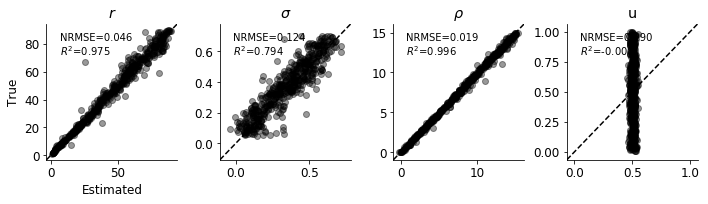

In [164]:
plot_true_est_scatter(vae_iaf, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

### Full posteriors

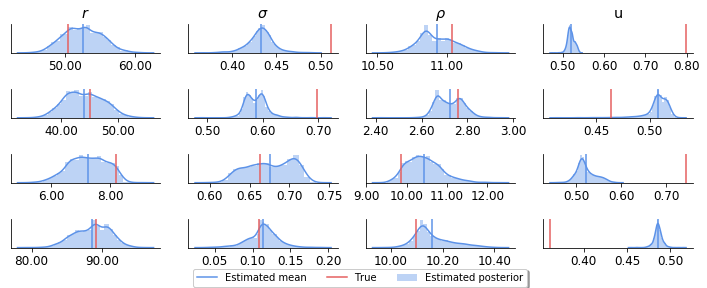

In [63]:
plot_true_est_posterior(vae_iaf, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))

### Errors

In [64]:
n_bootstrap = 100
theta_samples = vae_iaf.sample(X_test, n_samples_posterior, to_numpy=True)
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples, theta_test, simulate_ricker_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_cVAE_IAF.pkl', 'wb+'))

# ABC Random Forest

## Load test data

In [4]:
X_test, theta_test = load_test_ricker()

## SImulate a reference table

In [5]:
def simulate_ricker_abcrf(n_simulations, summary_net, n_pro_chunk=1000, n_points=None):
    """
    Simulates multiple Ricker simulations and summarizes them using the summaries from cINN.
    Stores eveything in a list.
    """
    
    X_train = []
    theta_train = []
    n_chunks = n_simulations // n_pro_chunk
    
    for i in range(n_chunks):
        
        X_train_chunk, theta_train_chunk = simulate_ricker(n_pro_chunk, n_points=n_points)
        X_train_chunk, theta_train_chunk = add_noise_var(X_train_chunk, theta_train_chunk)
        X_train_chunk = summary_net(X_train_chunk, training=False).numpy()
        
        X_train.append(X_train_chunk)
        theta_train.append(theta_train_chunk.numpy())
        
        if i % 10 == 0:
            print('Simulated {} chunks a {} datasets'.format(i, n_pro_chunk))
        
    return np.concatenate(X_train, axis=0), np.concatenate(theta_train, axis=0)

## Store test data

In [40]:
# X_test = model.summary_net(X_test).numpy()
# np.savetxt('./sim_data/ricker_test500/X_test.csv', X_test, delimiter=';')
# np.savetxt('./sim_data/ricker_test500/theta_test.csv', theta_test, delimiter=';')

In [17]:
# n_simulation_train = 200000
# X_train_ricker, theta_train_ricker = simulate_ricker_abcrf(n_simulation_train, model.summary_net, n_points=500)
# np.savetxt('./sim_data/ricker_reftable/X_train.csv', X_train_ricker, delimiter=';')
# np.savetxt('./sim_data/ricker_reftable/theta_train.csv', theta_train_ricker, delimiter=';')

## Evaluate the model

In [6]:
theta_hat = np.loadtxt('./sim_data/ricker_results_rf/theta_means_rf.csv', delimiter=';', skiprows=1)

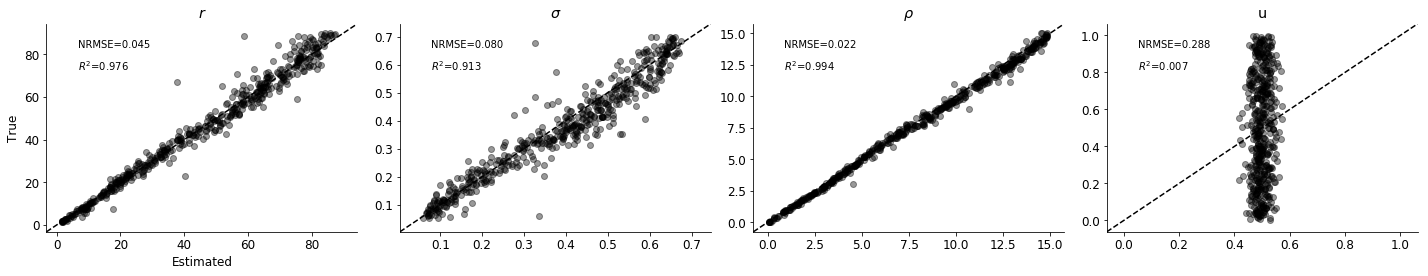

In [9]:
plot_true_est_scatter(None, None, theta_test, None, param_names, theta_approx_means=theta_hat)

### RMSE

In [16]:
# if type(theta_test) is not np.ndarray:
#     theta_test = theta_test.numpy()

# metrics_rf = {
#     'rmse': [],
#     'r2': [],
#     'resim': []
# }


# n_bootstrap = 100
# for bi in range(n_bootstrap):
        
#     # Get bootstrap samples
#     b_idx = np.random.choice(np.random.permutation(theta_test.shape[0]), size=theta_test.shape[0], replace=True)
#     theta_test_b = theta_test[b_idx]
#     theta_hat_b = theta_hat[b_idx]

#     rmse = diag.rmse(theta_hat_b[np.newaxis, :, :], theta_test_b)
#     r2 = diag.R2(theta_hat_b[np.newaxis, :, :], theta_test_b)
#     resim = diag.resimulation_error(theta_hat_b[np.newaxis, :, :], theta_test_b, simulate_ricker_params)
    
#     metrics_rf['rmse'].append(rmse)
#     metrics_rf['r2'].append(r2)
#     metrics_rf['resim'].append(resim)
#pickle.dump(metrics_rf, open('results/errors_rf.pkl', 'wb+'))

In [12]:
metrics_rf['rmse'] = np.array(metrics_rf['rmse'])
metrics_rf['r2'] = np.array(metrics_rf['r2'])

In [14]:
print('Parameter r: ')
print('Mean rmse: ', np.mean(metrics_rf['rmse'][:, 0]))
print('Std rmse: ', np.std(metrics_rf['rmse'][:, 0], ddof=1))
print('Mean r2: ', np.mean(metrics_rf['r2'][:, 0]))
print('Std r2: ', np.std(metrics_rf['r2'][:, 0], ddof=1))

print('Parameter sigma: ')
print('Mean rmse: ', np.mean(metrics_rf['rmse'][:, 1]))
print('Std rmse: ', np.std(metrics_rf['rmse'][:, 1], ddof=1))
print('Mean r2: ', np.mean(metrics_rf['r2'][:, 1]))
print('Std r2: ', np.std(metrics_rf['r2'][:, 1], ddof=1))

print('Parameter rho: ')
print('Mean rmse: ', np.mean(metrics_rf['rmse'][:, 2]))
print('Std rmse: ', np.std(metrics_rf['rmse'][:, 2], ddof=1))
print('Mean r2: ', np.mean(metrics_rf['r2'][:, 2]))
print('Std r2: ', np.std(metrics_rf['r2'][:, 2], ddof=1))


print('Mean re-sim: ', np.mean(metrics_rf['resim']))
print('Std re-sim: ', np.std(metrics_rf['resim'], ddof=1))

Parameter r: 
Mean rmse:  0.04424256348201523
Std rmse:  0.003740541484641836
Mean r2:  0.976502834637882
Std r2:  0.004335492903533989
Parameter sigma: 
Mean rmse:  0.08049218374521075
Std rmse:  0.004895384882076124
Mean r2:  0.9120616777274249
Std r2:  0.0118806642749157
Parameter rho: 
Mean rmse:  0.02148609725883969
Std rmse:  0.0013771861981290686
Mean r2:  0.9942698636543633
Std r2:  0.0008117755274081373
Mean re-sim:  0.041299257
Std re-sim:  0.0010709796


# PYABC - ABC-SMC

In [ ]:
### Not performing - too slow

In [ ]:
import pyabc
import tempfile
import os

## Summary network

In [ ]:
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
summary_dim = 64
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = 4
summary_dim = 64
n_inv_blocks = 10
global_step = tfe.Variable(0, dtype=tf.int32)



summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

checkpoint = tf.train.Checkpoint(step=global_step, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)

## Load test data

In [ ]:
X_test, theta_test = load_test_ricker()
X_test = model.summary_net(X_test, training=False).numpy()

## PYABC simulator function

In [ ]:
def pyabc_simulator(parameters):
    """
    Simulates from the Ricker model.
    """
    
    # Extract parameters
    r = parameters['r']
    sigma = parameters['sigma']
    rho = parameters['rho']
    
    # Simulate a Ricker dataset and summarize using summary
    data = simulate_ricker_params(np.array([[r, sigma, rho]]), to_tensor=True)
    data = model.summary_net(data, training=False).numpy()
    
    return {"data": data}

## Priors

In [ ]:
prior = pyabc.Distribution(r=pyabc.RV("uniform", 1, 90),
                           sigma=pyabc.RV("uniform", 0.05, 0.7),
                           rho=pyabc.RV("uniform", 0, 15),
                           u=pyabc.RV("uniform", 0, 1))

## Distance

In [ ]:
def distance(X, Y):
    """
    Compute eucledean distance between the summaries.
    """

    return np.sqrt(np.mean( (X['data'] - Y['data'])**2))

In [ ]:
%%time

# So slow that we probably need to run this in chunks

n_test = int(X_test.shape[0])
max_populations = 10
min_epsilon = 0.1

for i in range(n_test):
    
    print('Estimating', i, 'dataset...')
    test_data = {'data': X_test[i:(i+1)]}
    abc = pyabc.ABCSMC(pyabc_simulator, prior, distance, population_size=n_samples_posterior)

    # db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))
    db_path = "sqlite://"
    abc.new(db_path, test_data)
    
    history = abc.run(minimum_epsilon=min_epsilon, max_nr_populations=max_populations)
    
    r = history.get_distribution(m=0)[0]['r'].values
    sigma = history.get_distribution(m=0)[0]['sigma'].values
    rho = history.get_distribution(m=0)[0]['rho'].values
    u = history.get_distribution(m=0)[0]['u'].values
    theta_abc = np.stack((r, sigma, rho, u), axis=1)
    
    np.save('sim_data/ricker_results_abcsmc/{}_abc_posteriors.npy'.format(i+1), theta_abc)

# ABC NeuralNet

Use a neural network trained to output the posterior expectation of parameters as in Jiang et al. (2017).

## Load test data

In [69]:
X_test, theta_test = load_test_ricker()

In [ ]:
def simulate_ricker_abcnn(n_simulations, model, n_pro_chunk=1000, n_points=500):
    """
    Simulates multiple Ricker simulations and summarizes them using the summaries from cINN.
    Stores eveything in a list.
    """
    
    X_train = []
    theta_train = []
    n_chunks = n_simulations // n_pro_chunk
    
    for i in range(n_chunks):
        
        X_train_chunk, theta_train_chunk = simulate_ricker(n_pro_chunk, n_points=n_points)
        X_train_chunk, theta_train_chunk = add_noise_var(X_train_chunk, theta_train_chunk)
        X_train_chunk = model(X_train_chunk)[0].numpy()
        
        X_train.append(X_train_chunk)
        theta_train.append(theta_train_chunk.numpy())
        
        if i % 10 == 0:
            print('Simulated {} chunks a {} datasets'.format(i, n_pro_chunk))
        
    return np.concatenate(X_train, axis=0), np.concatenate(theta_train, axis=0)

In [ ]:
# n_simulation_train = 300000
# X_train_ricker, theta_train_ricker = simulate_ricker_abcnn(n_simulation_train, model)
# np.savetxt('./sim_data/ricker_reftable/X_train_nn.csv', X_train_ricker, delimiter=';')
# np.savetxt('./sim_data/ricker_reftable/theta_train_nn.csv', theta_train_ricker, delimiter=';')

In [ ]:
# Summarize sumstats
X_test_sum = model(X_test)[0].numpy()

## Rejection sampling

In [ ]:
def abc_reject(X_ref, theta_ref, X_test, n_samples=2000):
    """
    Performs rejection sampling given ref table and X_test.
    eps = n_samples / n_sim
    """
    
    # Standardize ref and test
    X_ref_mean = X_ref.mean(0)
    X_ref_std = X_ref.std(0, ddof=1)
    X_ref = (X_ref - X_ref_mean) / X_ref_std
    X_test = (X_test - X_ref_mean) / X_ref_std
    
    samples = []
    
    for i in range(X_test.shape[0]):
        
        # Compute distance, sort and get closest samples
        samples_i = np.argsort(np.linalg.norm(X_ref - X_test[i], axis=1))[:n_samples]
        samples.append(np.take(theta_ref, samples_i, axis=0))
    return np.stack(samples, axis=1)

In [166]:
# theta_approx_samples = abc_reject(X_train_ricker, theta_train_ricker, X_test_sum)
# np.save('sim_data/ricker_results_abcnn/theta_samples_abcnn.npy', theta_approx_samples)
theta_samples_abcnn = np.load('sim_data/ricker_results_abcnn/theta_samples_abcnn.npy')

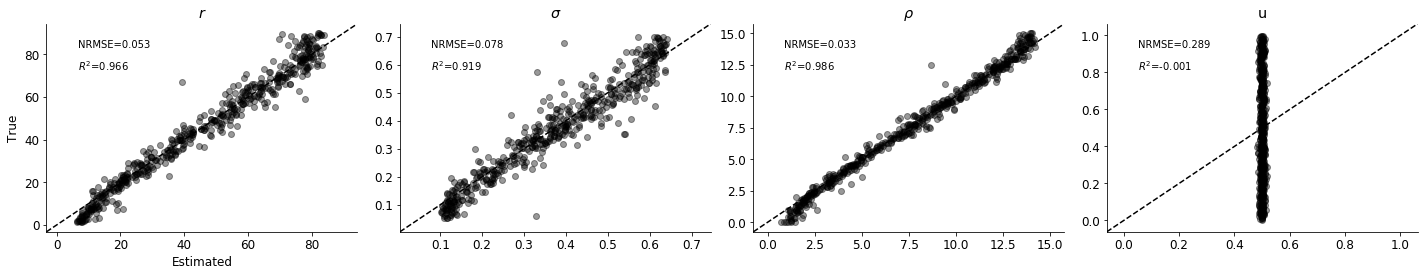

In [72]:
plot_true_est_scatter(None, None, theta_test, n_samples_posterior, 
                      param_names, theta_approx_means=theta_samples_abcnn.mean(0))

In [73]:
n_bootstrap = 100
with tqdm(total=n_bootstrap, desc='Bootstrapping metrics...') as p_bar:
    b = diag.bootstrap_metrics(theta_samples_abcnn, theta_test, simulate_ricker_params, p_bar, n_bootstrap)
pickle.dump(b, open('results/errors_ABC_NN.pkl', 'wb+'))

# Summary of the metrics for sampling models

In [10]:
metric_files = ['errors_{}'.format(method) for method in ['cINN', 'cVAE', 'cVAE_IAF', 'di', 'ABC_NN']]
methods = ['cINN', 'cVAE', 'cVAE_IAF', 'DeepI', 'ABC_NN']

In [88]:
p_names = ['r', 'sigma', 'rho']
metrics = ['ce', 'nrmse', 'r2']
idx = pd.MultiIndex.from_product([metrics, p_names])

all_metrics = np.empty((9, 5), dtype='<U32')
all_metrics_n = np.zeros((9, 5))
res_errors = []

for j, metric_file in enumerate(metric_files):
    
    # Read in metrics
    m = pickle.load(open('results/' + metric_file + '.pkl', 'rb+'))
    
    
    # Calibration error
    ce = m['cal_err']
    m_cal_errors = [np.mean(ce[:, i]) for i, _ in enumerate(p_names)]
    std_cal_errors = [np.std(ce[:, i], ddof=1) for i, _ in enumerate(p_names)]
    m_std_cal_errors = ['{0:.3f} +- {1:.3f}'.format(m, std) for m, std in zip(m_cal_errors, std_cal_errors)]

    
    # NRMSE
    nrmse = m['rmse']
    m_nrmse = [np.mean(nrmse[:, i]) for i, _ in enumerate(p_names)]
    std_nrmse = [np.std(nrmse[:, i], ddof=1) for i, _ in enumerate(p_names)]
    m_std_nrmse = ['{0:.3f} +- {1:.3f}'.format(m, std) for m, std in zip(m_nrmse, std_nrmse)]
    
    # R2
    r2 = m['r2']
    m_r2 = [np.mean(r2[:, i]) for i, _ in enumerate(p_names)]
    std_r2 = [np.std(r2[:, i], ddof=1) for i, _ in enumerate(p_names)]
    m_std_r2 = ['{0:.3f} +- {1:.3f}'.format(m, std) for m, std in zip(m_r2, std_r2)]
    
    all_metrics[:, j] = np.array(m_std_cal_errors + m_std_nrmse + m_std_r2, dtype=str) 
    all_metrics_n[:, j] = np.array(m_cal_errors + m_nrmse + m_r2)
    
    # Resimulation
    res = m['res_err']
    m_res = np.mean(res)
    std_res = np.std(res, ddof=1)
    res_errors.append((m_res, std_res))
    
df_s = pd.DataFrame(all_metrics, index=idx, columns=methods)
df = pd.DataFrame(all_metrics_n, index=idx, columns=methods)

In [89]:
df.transpose()

ce                       nrmse                            r2  \
                r    sigma      rho         r     sigma       rho         r   
cINN      0.01688  0.01331  0.08400  0.040905  0.077050  0.017534  0.979986   
cVAE      0.01427  0.41940  0.12101  0.047223  0.136783  0.016196  0.973038   
cVAE_IAF  0.05826  0.38169  0.18806  0.046714  0.124029  0.018677  0.973463   
DeepI     0.12244  0.18416  0.11135  0.051714  0.108361  0.018859  0.967809   
ABC_NN    0.16428  0.11943  0.28302  0.053061  0.077230  0.033129  0.966444   

                              
             sigma       rho  
cINN      0.919458  0.996208  
cVAE      0.744531  0.996746  
cVAE_IAF  0.792394  0.995698  
DeepI     0.840945  0.995569  
ABC_NN    0.918621  0.986338

In [91]:
df_s.transpose()

ce                                           nrmse  \
                       r           sigma             rho               r   
cINN      0.017 +- 0.007  0.013 +- 0.007  0.084 +- 0.018  0.041 +- 0.002   
cVAE      0.014 +- 0.007  0.419 +- 0.011  0.121 +- 0.017  0.047 +- 0.004   
cVAE_IAF  0.058 +- 0.017  0.382 +- 0.013  0.188 +- 0.018  0.047 +- 0.006   
DeepI     0.122 +- 0.016  0.184 +- 0.021  0.111 +- 0.019  0.052 +- 0.003   
ABC_NN    0.164 +- 0.015  0.119 +- 0.014  0.283 +- 0.012  0.053 +- 0.003   

                                                      r2                  \
                   sigma             rho               r           sigma   
cINN      0.077 +- 0.005  0.018 +- 0.001  0.980 +- 0.003  0.919 +- 0.011   
cVAE      0.137 +- 0.004  0.016 +- 0.002  0.973 +- 0.005  0.745 +- 0.020   
cVAE_IAF  0.124 +- 0.006  0.019 +- 0.002  0.973 +- 0.007  0.792 +- 0.020   
DeepI     0.108 +- 0.004  0.019 +- 0.002  0.968 +- 0.005  0.841 +- 0.014   
ABC_NN    0.077 +- 0.004  0.033 +- 0.002  0.966 +- 0.004  0.919 +- 0.010   

                          
                     rho  
cINN      0.996 +- 0.001  
cVAE      0.997 +- 0.001  
cVAE_IAF  0.996 +- 0.001  
DeepI     0.996 +- 0.001  
ABC_NN    0.986 +- 0.002

In [93]:
with open('results\latex_tab.txt', 'w') as f:
    f.write(df_s.to_latex(multicolumn=True))

In [94]:
print(res_errors)

[(0.037720736, 0.0009797324), (0.04054005, 0.00121459), (0.041972872, 0.0013574483), (0.04125941, 0.0013598634), (0.048103414, 0.002195482)]


In [188]:
# Posteriors plots for each method
models_strs = ['cINN', 'cVAE', 'cVAE-IAF', 'DeepInference', 'ABC-NN']

models_samples = [
    model.sample(X_test[0:1], n_samples_posterior).numpy(),
    vae.sample(X_test[0:1], n_samples_posterior).numpy()[:, 0, :],
    vae_iaf.sample(X_test[0:1], n_samples_posterior).numpy()[:, 0, :],
    model_di.sample(X_test[0:1], n_samples_posterior).numpy()[:, 0, :],
    theta_samples_abcnn[:, 0, :]
]

models_means = [
    ms.mean(axis=0)
    for ms in models_samples
]

true_params = theta_test[0].numpy()

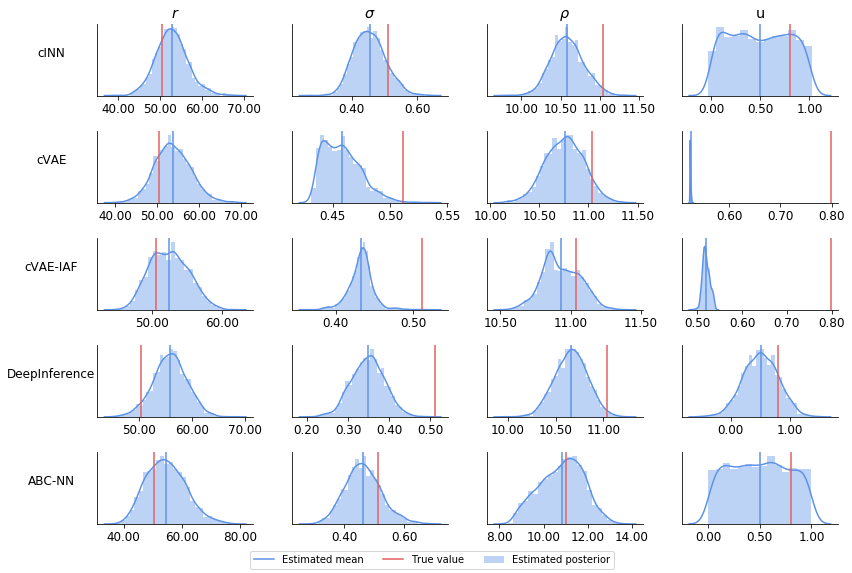

In [225]:
plt.rcParams['font.size'] = 12

f, axarr = plt.subplots(len(models_strs), len(param_names), figsize=(12, 8))

for mi, (model_str, model_samples, sample_means) in enumerate(zip(models_strs, models_samples, models_means)):
    for pi, p in enumerate(param_names):
        sns.distplot(model_samples[:, pi], kde=True, hist=True, ax=axarr[mi, pi], 
                     color='#5c92e8', label='Estimated posterior')
        
        
        # Plot lines for approximate mean, analytic mean and true data-generating value
        axarr[mi, pi].axvline(sample_means[pi], color='#5c92e8', label='Estimated mean')
        axarr[mi, pi].axvline(true_params[pi], color='#e55e5e', label='True value')
        axarr[mi, pi].spines['right'].set_visible(False)
        axarr[mi, pi].spines['top'].set_visible(False)
        axarr[mi, pi].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axarr[mi, pi].get_yaxis().set_ticks([])
        
        if pi == 0:
            axarr[mi, pi].set_ylabel(model_str, rotation=0, labelpad=46)
        if mi == 0:
            axarr[mi, pi].set_title(p)
        if mi == 0 and pi == 0:
            f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=5, fontsize=10, borderaxespad=1)
        
f.tight_layout()
f.subplots_adjust(bottom=0.08)

f.savefig('figures/ricker_comparison.png', dpi=600, bbox_inches='tight')